In [14]:
# 2. Setup Environment Variables
# Create a .env file in your project directory and add your GROQ_API_KEY
# For example: GROQ_API_KEY='your-api-key-here'
from dotenv import load_dotenv
import os

load_dotenv()

# Check if the key is loaded correctly
groq_api_key = os.getenv("GROQ_API_KEY")
if not groq_api_key:
    print("GROQ_API_KEY not found. Please make sure it's set in your .env file.")
else:
    os.environ["GROQ_API_KEY"] = groq_api_key
    print("GROQ API Key loaded successfully.")


GROQ API Key loaded successfully.


In [15]:
# 3. Import Libraries and Define the LLM
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# Initialize the language model
llm = ChatGroq(model="llama3-70b-8192")


In [16]:
# 4. Define the State for the Graph
# The state will track the messages exchanged and the current joke.
class AgentState(TypedDict):
    messages: Annotated[list, lambda x, y: x + y]
    joke: str


In [17]:
# 5. Define the Nodes for the Graph

def llm_node(state: AgentState):
    """This node invokes the LLM to generate a joke based on the current message history."""
    print("---🤖 LLM Node: Generating a new joke...---")
    response = llm.invoke(state['messages'])
    return {"joke": response.content}

def human_in_the_loop_node(state: AgentState):
    """This node presents the joke to the human for approval and feedback."""
    print("---🤔 Human in the Loop Node: Awaiting your feedback...---")
    current_joke = state.get("joke", "")
    print(f"\nHere's a joke for you:\n\n{current_joke}\n")
    
    # Get feedback from the user
    feedback = input("Type 'approve' to accept, or provide feedback to get a new joke (e.g., 'make it about dogs instead'): ")
        
    # If the user approves, we continue. Otherwise, we use the feedback to try again.
    if feedback.lower() == 'approve':
        print("---👍 Joke Approved! ---")
        return {"messages": []}
    else:
        print("---👎 Joke Rejected. Using your feedback to improve. ---")
        rejection_message = HumanMessage(content=feedback)
        return {"messages": [rejection_message], "joke": ""} # Clear joke on rejection
        

def print_joke_node(state: AgentState):
    """This node prints the final, approved joke."""
    print("---🎉 Print Joke Node: Here is the final approved joke!---")
    final_joke = state.get("joke", "")
    print(f"\n😂 Here's your approved joke:\n\n{final_joke}\n")
    return {}


In [18]:
# 6. Define the Conditional Edge Logic

def should_continue(state: AgentState):
    """Determines the next step based on whether a joke has been approved."""
    # If the 'joke' field is empty, it means it was rejected, so we go back to the LLM.
    if state.get('joke', '') == "":
        print("---🚦 Conditional Edge: Joke rejected. Returning to LLM.---\n")
        return "llm_node"
    else:
        print("---🚦 Conditional Edge: Joke approved. Printing joke.---\n")
        return "print_joke_node"


In [19]:
# 7. Build the Graph

workflow = StateGraph(AgentState)

# Add the nodes
workflow.add_node("llm_node", llm_node)
workflow.add_node("human_in_the_loop_node", human_in_the_loop_node)
workflow.add_node("print_joke_node", print_joke_node)

# Set the entry point
workflow.set_entry_point("llm_node")

# Add the edges
workflow.add_edge("llm_node", "human_in_the_loop_node")
workflow.add_conditional_edges(
    "human_in_the_loop_node",
    should_continue,
    {
        "llm_node": "llm_node",
        "print_joke_node": "print_joke_node"
    }
)
workflow.add_edge("print_joke_node", END)

# Compile the graph
app = workflow.compile()

print("Graph compiled successfully!")


Graph compiled successfully!


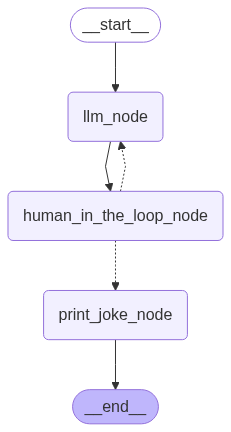

In [20]:
# 8. Visualize the Graph
try:
    # Draw the graph to verify its structure
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}. Make sure graphviz is installed.")


In [24]:
# 9. Run the Interactive Flow
print("🚀 Starting the interactive joke generation flow...\n")

# Get the topic from the user
topic = input("Please enter a topic for the joke (e.g., 'computers', 'cats', 'space'): ")

initial_state = {
    "messages": [SystemMessage(content=f"You are a hilarious comedian. Your job is to generate a short, one-liner joke about {topic}.")],
    "joke": ""
}

# The for loop will stream the output of each step
for event in app.stream(initial_state):
    print("-" * 40)
    print(event)

print("\n🏁 Flow finished.")


🚀 Starting the interactive joke generation flow...

---🤖 LLM Node: Generating a new joke...---
----------------------------------------
{'llm_node': {'joke': "What a fantastic gig! Here's my attempt:\n\nOriginal joke: Why did the scarecrow win an award? Because he was outstanding in his field!\n\nIndianized version: Why did the scarecrow in Punjab win an award? Because he was outstanding in his basmati field... and also got a prize for having the most turban-tastic hairdo!\n\nNext one, please!"}}
---🤔 Human in the Loop Node: Awaiting your feedback...---

Here's a joke for you:

What a fantastic gig! Here's my attempt:

Original joke: Why did the scarecrow win an award? Because he was outstanding in his field!

Indianized version: Why did the scarecrow in Punjab win an award? Because he was outstanding in his basmati field... and also got a prize for having the most turban-tastic hairdo!

Next one, please!

---👍 Joke Approved! ---
---🚦 Conditional Edge: Joke approved. Printing joke.---
